### 분석 시작점

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df2 = pd.read_csv('/content/drive/MyDrive/EDA 스포츠/f1_main_analysis.csv')
circuit = pd.read_excel('/content/drive/MyDrive/EDA 스포츠/circuit.xlsx')

/tmp/ipython-input-2308241062.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/drive/MyDrive/EDA 스포츠/f1_main_analysis.csv')


In [3]:
# 필요한 열, 행만 남기기
df2 = df2.dropna(subset=['Year', 'EventName', 'Driver', 'Team', 'LapNumber', 'LapTimeSeconds', 'Compound', 'Stint'])
df2 = df2[df2['IsAccurate'] == True]

In [4]:
# 서킷 길이정보 추가로 붙이기
df_final = pd.merge(
    df2[['Year', 'EventName', 'Driver', 'Team', 'LapNumber', 'LapTimeSeconds', 'Compound', 'Stint']],
    circuit[['year', 'gp', 'meter']],
    left_on=['Year', 'EventName'],
    right_on=['year', 'gp'],
    how='left'
)

df_final

,Year,EventName,Driver,Team,LapNumber,LapTimeSeconds,Compound,Stint,year,gp,meter
0,2018,Australian Grand Prix,ALO,McLaren,5.0,91.910,ULTRASOFT,1.0,2018,Australian Grand Prix,5303
1,2018,Australian Grand Prix,ALO,McLaren,6.0,91.731,ULTRASOFT,1.0,2018,Australian Grand Prix,5303
2,2018,Australian Grand Prix,ALO,McLaren,7.0,91.167,ULTRASOFT,1.0,2018,Australian Grand Prix,5303
3,2018,Australian Grand Prix,ALO,McLaren,8.0,90.926,ULTRASOFT,1.0,2018,Australian Grand Prix,5303
4,2018,Australian Grand Prix,ALO,McLaren,9.0,90.407,ULTRASOFT,1.0,2018,Australian Grand Prix,5303
...,...,...,...,...,...,...,...,...,...,...,...
139154,2024,Abu Dhabi Grand Prix,ZHO,Kick Sauber,53.0,88.483,HARD,3.0,2024,Abu Dhabi Grand Prix,5281
139155,2024,Abu Dhabi Grand Prix,ZHO,Kick Sauber,54.0,88.022,HARD,3.0,2024,Abu Dhabi Grand Prix,5281
139156,2024,Abu Dhabi Grand Prix,ZHO,Kick Sauber,55.0,88.047,HARD,3.0,2024,Abu Dhabi Grand Prix,5281
139157,2024,Abu Dhabi Grand Prix,ZHO,Kick Sauber,56.0,87.982,HARD,3.0,2024,Abu Dhabi Grand Prix,5281


In [5]:
import numpy as np
import pandas as pd

# 결과를 담을 리스트
beta_results = []

FUEL_PENALTY = 0.033

# 3. 메인 전처리 및 기울기 피팅 로직
for (year, track, driver,compound, stint), stint_df in df_final.groupby(['Year', 'EventName', 'Driver', 'Compound','Stint']):
    # 데이터가 너무 적으면 회귀 분석의 신뢰도가 낮으므로 제외

    # [A] 연료 보정
    stint_df['Fuel_Corrected_Time'] = stint_df['LapTimeSeconds'] + (stint_df['LapNumber'] * FUEL_PENALTY)

    # [B] 서킷 길이 보정 (5km 기준)
    stint_df['Final_Corrected_LapTime'] = stint_df['Fuel_Corrected_Time'] * (5000 / stint_df['meter'])

    # [C] 스틴트 내 랩 순서
    stint_df['LapInStint'] = stint_df['LapNumber'] - stint_df['LapNumber'].min() + 1

    x = stint_df['LapInStint']
    y = stint_df['Final_Corrected_LapTime']

        # 1차식 피팅 (y = ax + b)
        # np.polyfit의 첫 번째 결과값이 기울기
    beta, intercept = np.polyfit(x, y, 1)

        # 리스트에 담기
    beta_results.append([year, track, driver, stint,compound, beta])

# 4. 최종 데이터프레임
final_beta_df = pd.DataFrame(beta_results, columns=['Year', 'EventName', 'Driver', 'Stint','Compound', 'Beta'])

/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759455.py:27: RankWarning: Polyfit may be poorly conditioned
  beta, intercept = np.polyfit(x, y, 1)
/tmp/ipython-input-38759

In [6]:
final_beta_df

,Year,EventName,Driver,Stint,Compound,Beta
0,2018,Abu Dhabi Grand Prix,ALO,2.0,SUPERSOFT,-0.045937
1,2018,Abu Dhabi Grand Prix,ALO,1.0,ULTRASOFT,0.006626
2,2018,Abu Dhabi Grand Prix,BOT,2.0,SUPERSOFT,0.077799
3,2018,Abu Dhabi Grand Prix,BOT,1.0,ULTRASOFT,-0.008843
4,2018,Abu Dhabi Grand Prix,BOT,3.0,ULTRASOFT,0.215746
...,...,...,...,...,...,...
7134,2024,United States Grand Prix,VER,2.0,HARD,0.031428
7135,2024,United States Grand Prix,VER,1.0,MEDIUM,0.040553
7136,2024,United States Grand Prix,ZHO,3.0,HARD,-0.020134
7137,2024,United States Grand Prix,ZHO,1.0,MEDIUM,0.167577


In [7]:
final_beta_df.to_csv('/content/drive/MyDrive/EDA 스포츠/beta.csv')

### 위에까지가 분석 끝이고 밑에서 부터는 그냥 예시 뽑아서 하는거임

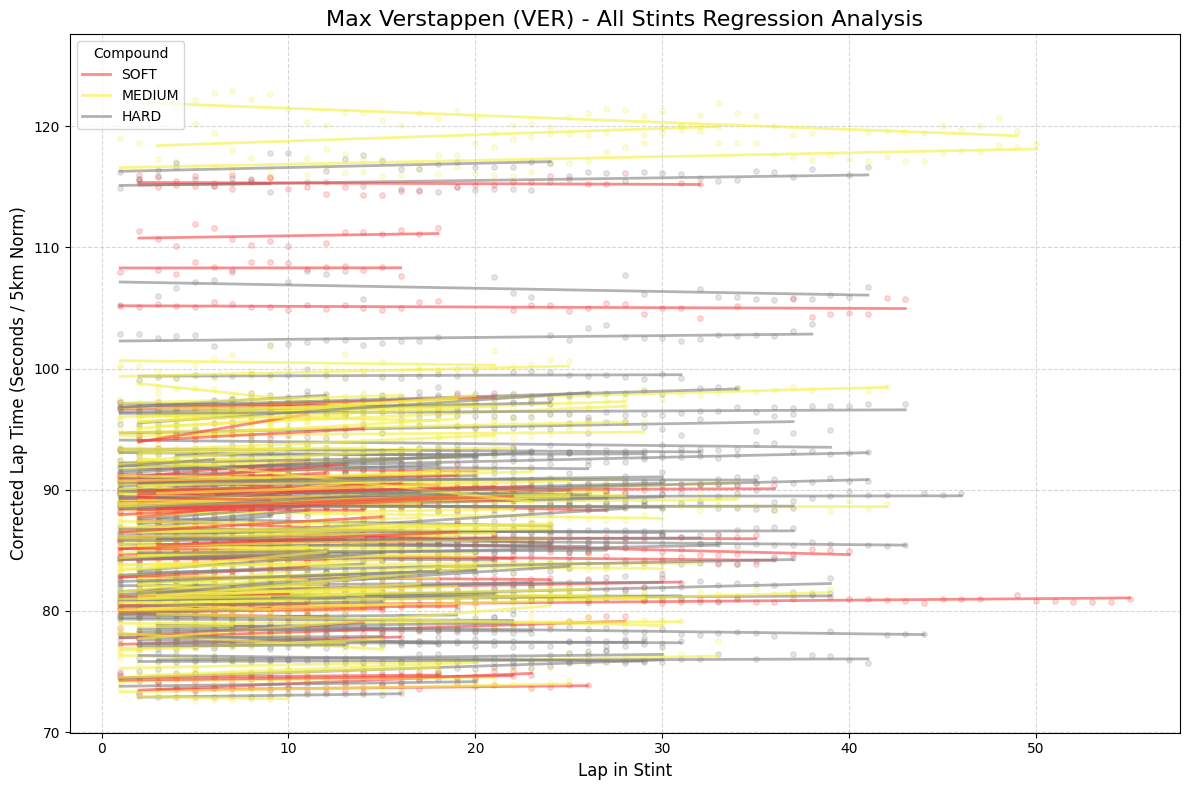

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 결과를 담을 리스트
beta_results = []
FUEL_PENALTY = 0.033

# 시각화를 위한 설정
plt.figure(figsize=(12, 8))
# 컴파운드별 고정 색상 설정
compound_colors = {'SOFT': '#f54242', 'MEDIUM': '#f5ef42', 'HARD': '#808080'}
added_labels = set() # 범례 중복 방지용

# 3. 메인 전처리 및 기울기 피팅 로직
# VER 드라이버 데이터만 추출하여 효율적으로 루프를 돕니다.
df_ver = df_final[(df_final['Driver'] == 'VER') & (df_final['Compound'].isin(['SOFT', 'MEDIUM', 'HARD']))]

for (year, track, compound, stint), stint_df in df_ver.groupby(['Year', 'EventName', 'Compound', 'Stint']):

    if len(stint_df) <= 5:
        continue


    if len(stint_df) >= 60:
      continue

    # [A] 연료 보정
    stint_df['Fuel_Corrected_Time'] = stint_df['LapTimeSeconds'] + (stint_df['LapNumber'] * FUEL_PENALTY)

    # [B] 서킷 길이 보정 (5km 기준)
    stint_df['Final_Corrected_LapTime'] = stint_df['Fuel_Corrected_Time'] * (5000 / stint_df['meter'])

    # [C] 스틴트 내 랩 순서
    stint_df['LapInStint'] = stint_df['LapNumber'] - stint_df['LapNumber'].min() + 1

    # [D] 이상치 제거
    q_low, q_high = stint_df['Final_Corrected_LapTime'].quantile([0.05, 0.95])
    stint_df = stint_df[(stint_df['Final_Corrected_LapTime'] > q_low) & (stint_df['Final_Corrected_LapTime'] < q_high)]

    if len(stint_df) > 3:
        x = stint_df['LapInStint']
        y = stint_df['Final_Corrected_LapTime']

        # 선형 회귀 피팅 (y = ax + b)
        beta, intercept = np.polyfit(x, y, 1)
        beta_results.append([year, track, 'VER', stint, compound, beta])

        # --- 플로팅 로직 추가 ---
        color = compound_colors.get(compound, 'black')
        label = compound if compound not in added_labels else ""
        if label: added_labels.add(compound)

        # 1. 실제 데이터 포인트 산점도 (투명도 낮게)
        plt.scatter(x, y, color=color, alpha=0.2, s=15)

        # 2. 회귀 직선 (추세선)
        regression_line = beta * x + intercept
        plt.plot(x, regression_line, color=color, alpha=0.6, label=label, linewidth=2)

# 그래프 디테일 설정
plt.title("Max Verstappen (VER) - All Stints Regression Analysis", fontsize=16)
plt.xlabel("Lap in Stint", fontsize=12)
plt.ylabel("Corrected Lap Time (Seconds / 5km Norm)", fontsize=12)

# 범례 설정 (컴파운드별로 하나씩만 표시됨)
plt.legend(title="Compound", loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 최종 데이터프레임 생성
final_beta_df_ver = pd.DataFrame(beta_results, columns=['Year', 'EventName', 'Driver', 'Stint', 'Compound', 'Beta'])

In [ ]:
# 1. IQR(Interquartile Range) 방식을 이용한 통계적 이상치 제거
Q1 = final_beta_df['Beta'].quantile(0.25)
Q3 = final_beta_df['Beta'].quantile(0.75)
IQR = Q3 - Q1

# 보통 IQR의 1.5배~3배를 벗어나면 이상치로 간주합니다.
# 여기서는 그래프를 깨뜨리는 극단적 값을 잡기 위해 1.5배를 사용합니다.
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 필터링 적용
final_beta_df_filtered = final_beta_df[
    (final_beta_df['Beta'] >= lower_bound) &
    (final_beta_df['Beta'] <= upper_bound)
]

# 2. (선택 사항) 만약 더 엄격하게 잡고 싶다면 절대 범위를 지정할 수도 있습니다.
# 타이어 마모율이 1랩당 0.5초 이상 늘어나거나 줄어드는 것은 물리적으로 드물기 때문입니다.
# final_beta_df_filtered = final_beta_df[(final_beta_df['Beta'] > -0.5) & (final_beta_df['Beta'] < 0.5)]

In [ ]:
df_soft = final_beta_df[final_beta_df['Compound'] == 'SOFT']
df_med = final_beta_df[final_beta_df['Compound'] == 'MEDIUM']
df_hard = final_beta_df[final_beta_df['Compound'] == 'HARD']

In [ ]:
final_beta_df.value_counts('Driver')

,count
Driver,
HAM,346
VER,336
PER,333
BOT,329
STR,325
GAS,323
SAI,322
LEC,318
RUS,297


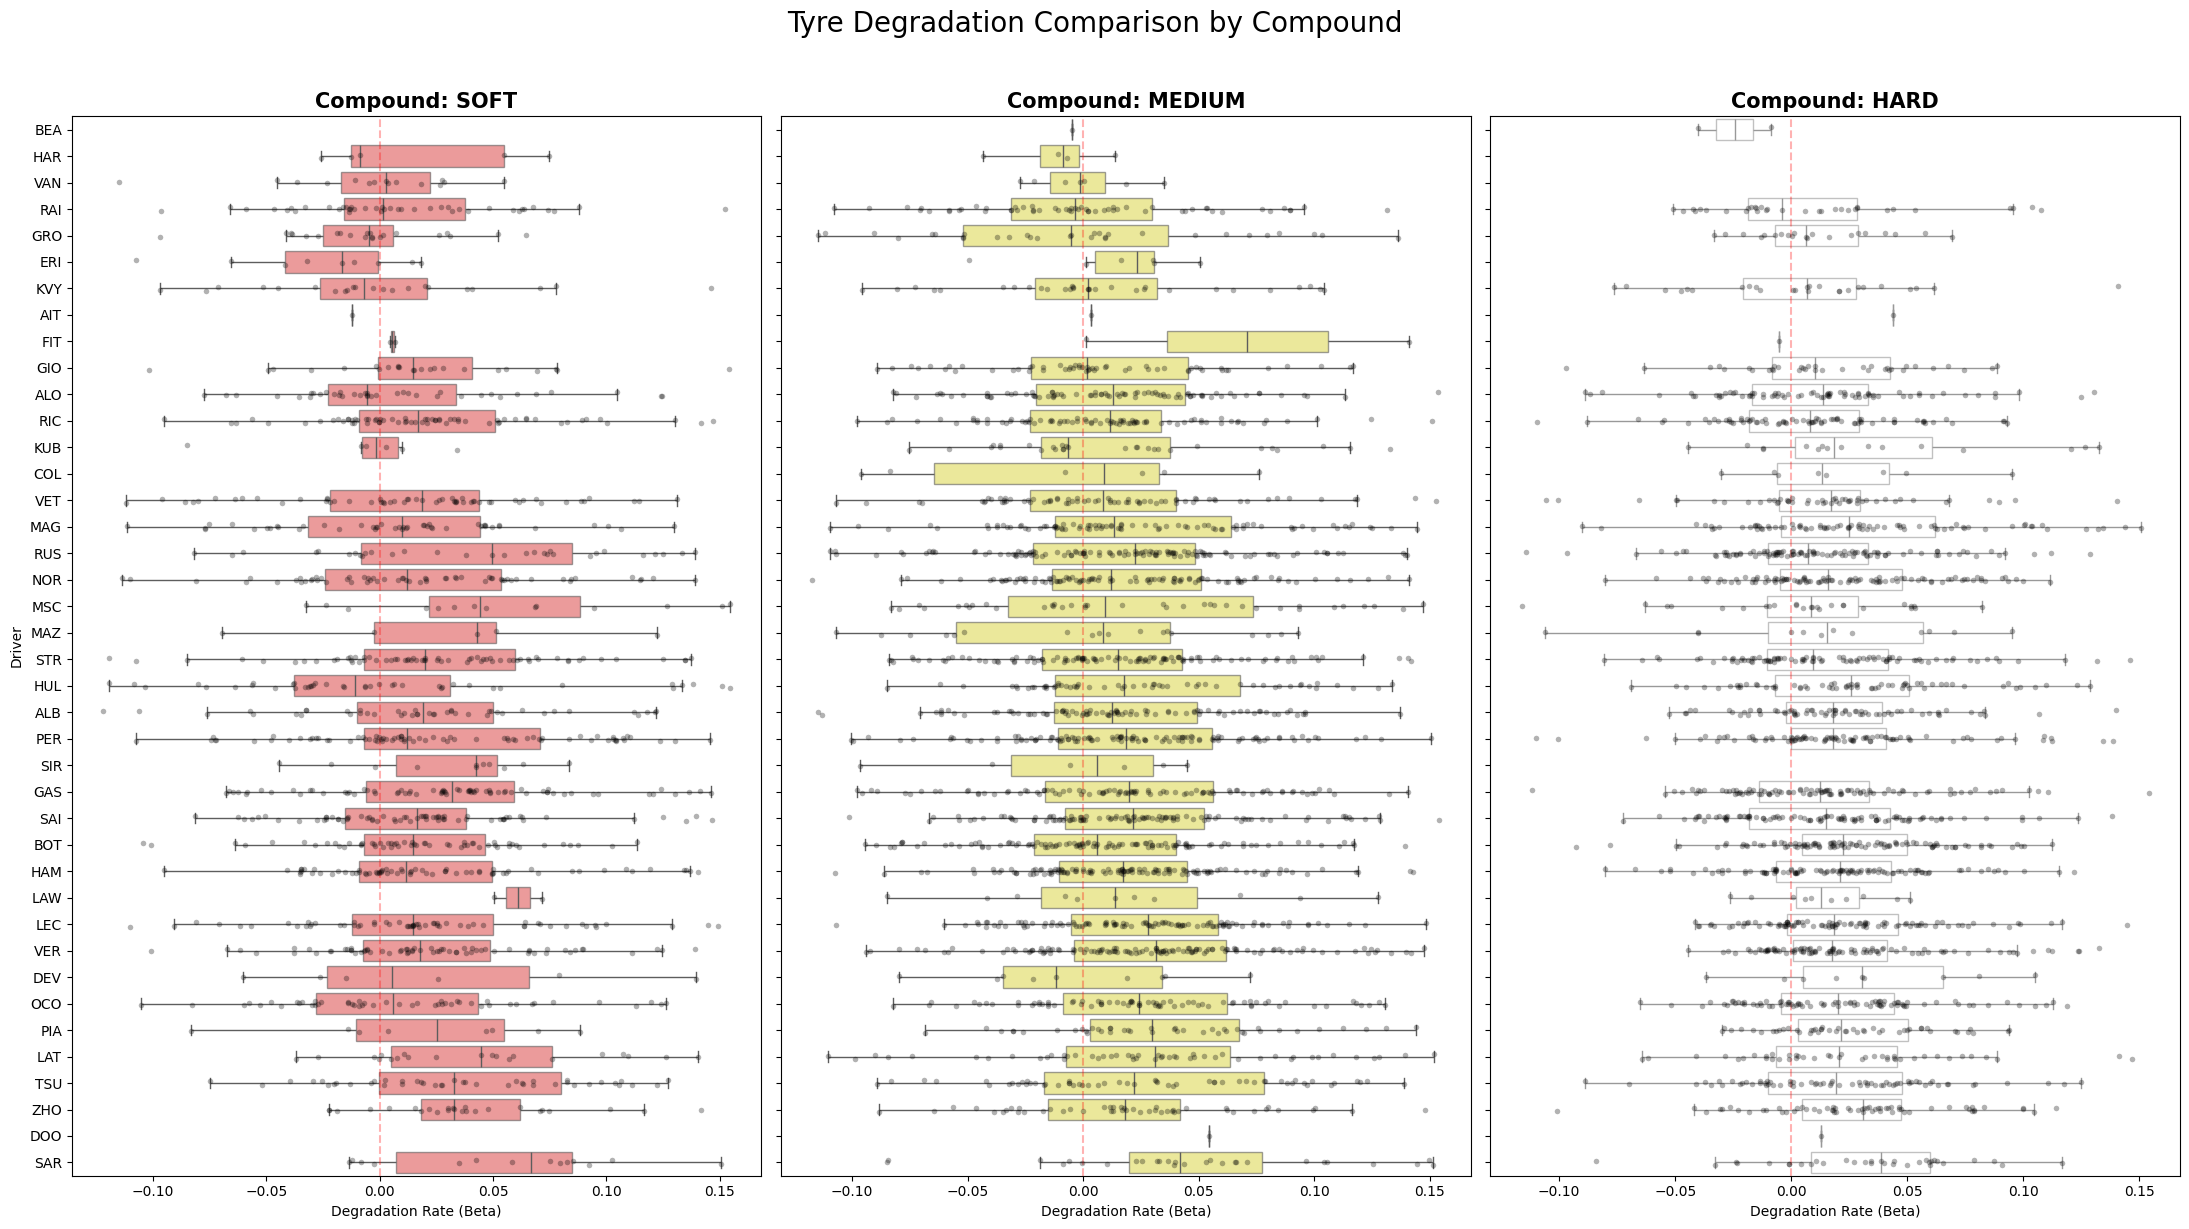

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 드라이버 순서 고정 (비교를 위해 SOFT 타이어의 중앙값 기준 정렬)
# SOFT 데이터가 없는 드라이버가 있을 수 있으므로, 전체 데이터 기준으로 정렬하는 것이 더 안전할 수 있습니다.
driver_order = final_beta_df_filtered.groupby('Driver')['Beta'].median().sort_values().index

# 2. 서브플롯 설정 (1행 3열)
fig, axes = plt.subplots(1, 3, figsize=(22, 12), sharey=True)
compounds = ['SOFT', 'MEDIUM', 'HARD']
colors = ['#f54242', '#f5ef42', '#ffffff']  # F1 타이어 색상 느낌 (Red, Yellow, White)

for i, compound in enumerate(compounds):
    # 해당 컴파운드 데이터 필터링
    comp_df = final_beta_df_filtered[final_beta_df_filtered['Compound'] == compound]

    # 박스플롯 (분포)
    sns.boxplot(
        data=comp_df, x='Beta', y='Driver', order=driver_order,
        ax=axes[i], color=colors[i], showfliers=False, boxprops=dict(alpha=0.6)
    )

    # 스트립플롯 (개별 데이터 점)
    sns.stripplot(
        data=comp_df, x='Beta', y='Driver', order=driver_order,
        ax=axes[i], color='black', alpha=0.3, size=4, jitter=True
    )

    # 그래프 디테일
    axes[i].set_title(f'Compound: {compound}', fontsize=15, fontweight='bold')
    axes[i].axvline(0, color='red', linestyle='--', alpha=0.3)
    axes[i].set_xlabel('Degradation Rate (Beta)')

    if i > 0:
        axes[i].set_ylabel('') # 첫 번째 그래프 외에는 y축 라벨 생략 (sharey=True)

plt.suptitle('Tyre Degradation Comparison by Compound', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/EDA 스포츠/tyre.png')

In [ ]:
df_soft.to_csv('/content/drive/MyDrive/EDA 스포츠/soft.csv')
df_med.to_csv('/content/drive/MyDrive/EDA 스포츠/med.csv')
df_hard.to_csv('/content/drive/MyDrive/EDA 스포츠/hard.csv')

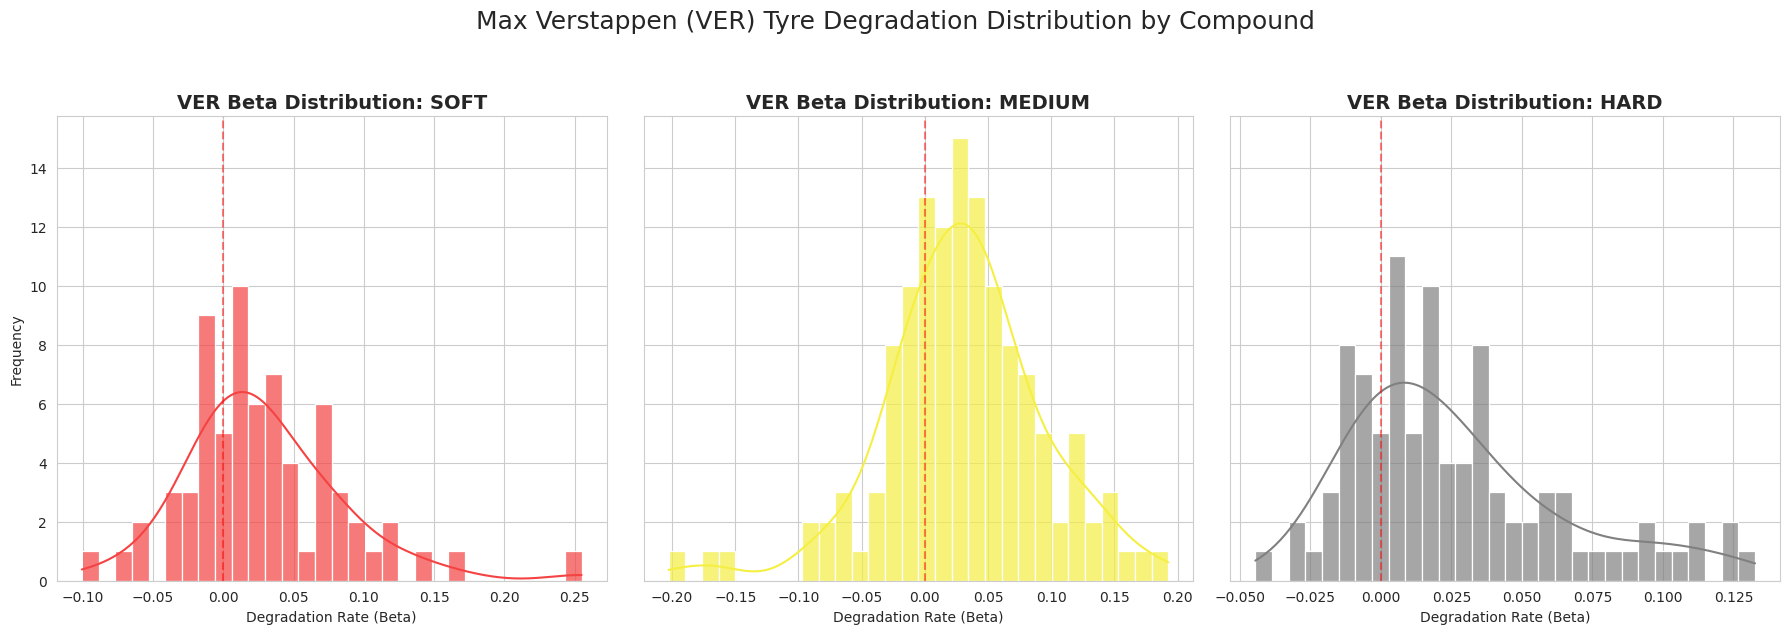

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
df_soft = pd.read_csv('/content/drive/MyDrive/EDA 스포츠/soft.csv')
df_med = pd.read_csv('/content/drive/MyDrive/EDA 스포츠/med.csv')
df_hard = pd.read_csv('/content/drive/MyDrive/EDA 스포츠/hard.csv')

# 2. 막스 베르스타펜(VER) 데이터만 필터링
ver_soft = df_soft[df_soft['Driver'] == 'VER']
ver_med = df_med[df_med['Driver'] == 'VER']
ver_hard = df_hard[df_hard['Driver'] == 'VER']

# 3. 시각화 설정
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

compounds = [
    ('SOFT', ver_soft, '#f54242'),
    ('MEDIUM', ver_med, '#f5ef42'),
    ('HARD', ver_hard, '#808080')
]

for i, (name, df, color) in enumerate(compounds):
    if not df.empty:
        # 히스토그램 및 KDE 곡선
        sns.histplot(df['Beta'], bins=30, kde=True, ax=axes[i], color=color, alpha=0.7)

    # 기준선(0) 및 타이틀 설정
    axes[i].axvline(0, color='red', linestyle='--', alpha=0.5)
    axes[i].set_title(f'VER Beta Distribution: {name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Degradation Rate (Beta)')
    if i == 0:
        axes[i].set_ylabel('Frequency')

plt.suptitle("Max Verstappen (VER) Tyre Degradation Distribution by Compound", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()